In [1]:
import os

# Check the current working directory
os.chdir('..')
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

Current working directory: /home/henry/robo/cis5810/final/cis5810_final_gait_classifier


In [20]:
import pandas as pd

# Load gavd_dataset
df = pd.read_pickle('data/gavd_dataset/annotations/gavd_annotations.pkl')

# keep only the rows with cam_view in ['front', 'back', 'left side', 'right side']
df = df[df['cam_view'].isin(['front', 'back', 'left side', 'right side'])]
# keep only the rows that image_exists is True
print(len(df))
df['image_exists'] = df.apply(lambda x: os.path.exists(f"data/gavd_dataset/frame_images/{x['seq']}/{x['seq']}_frame_{x['frame_num']}.jpg"), axis=1)
df = df[df['image_exists']]
print(len(df))
# randomly sample 20 frames from each seq unless there are less than 20 frames
df = df.groupby(['seq', 'cam_view']).apply(lambda x: x.sample(min(20, x.shape[0]))).reset_index(drop=True)

# create 3 datasets: train, val, test
train = df.sample(frac=0.7)
val_test = df.drop(train.index)
val = val_test.sample(frac=0.5)
test = val_test.drop(val.index)


456669
423101


In [26]:
import torch
from torchvision import transforms
from datasets.single_image_dataset import ImageDataset
from torch.utils.data import DataLoader

# Define transformations for the training, validation, and test sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit the model's input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet statistics
])

# Load datasets
train_data = ImageDataset(image_df=train, image_dir='data/gavd_dataset/frame_images', transform=transform)
val_data = ImageDataset(image_df=val, image_dir='data/gavd_dataset/frame_images', transform=transform)
test_data = ImageDataset(image_df=test, image_dir='data/gavd_dataset/frame_images', transform=transform)

# Create DataLoader for batching
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)


Dataset loaded with 25526 images
Dataset loaded with 5470 images
Dataset loaded with 5469 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224]) 1


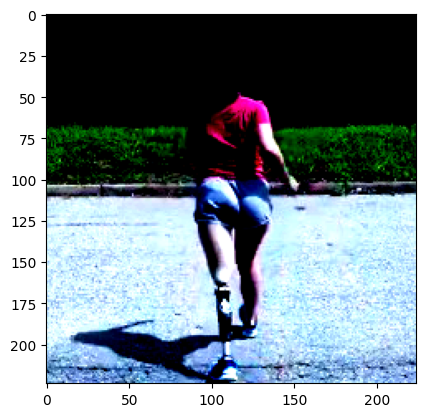

In [32]:
# visualize the data
import matplotlib.pyplot as plt
import numpy as np
import cv2

# display the image and label for one sample
image, label = train_data[0]
print(image.shape, label)
image = image.permute(1, 2, 0).numpy()
plt.imshow(image)
#

In [27]:
from torchvision import models

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Replace the final fully connected layer to match the number of classes (camera angles)
num_classes = 4  # Get the number of classes from the dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Send the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [28]:
import torch.optim as optim

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
from tqdm import tqdm
import time

# Training loop
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training phase
    start_time = time.time()
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero out previous gradients
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    elapsed_time = time.time() - start_time
    eta = elapsed_time * (num_epochs - epoch - 1)
    
    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    # Calculate accuracy
    train_acc = correct / total
    val_acc = val_correct / val_total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, ETA: {eta:.2f} seconds")
    
    # Save the model with the best validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'weights/cam_class.pth')


KeyboardInterrupt: 

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the best model
model.load_state_dict(torch.load('weights/cam_class.pth'))

# Test the model
model.eval()
test_correct = 0
test_total = 0
misclassified = []
correct = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
        # Save images for later
        for i in range(inputs.size(0)):
            img = inputs[i].permute(1, 2, 0).cpu().numpy()
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            if predicted[i] != labels[i]:
                misclassified.append((img, labels[i].item(), predicted[i].item()))
            else:  
                correct.append((img, labels[i].item(), predicted[i].item()))
    # print test accuracy
    print(f"Test Accuracy: {test_correct / test_total:.4f}")

# Display 10 misclassified images
plt.figure(figsize=(15, 15))
for i, (img, true_label, pred_label) in enumerate(misclassified[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
plt.show()

# Display 10 correctly classified images
plt.figure(figsize=(15, 15))
for i, (img, true_label, pred_label) in enumerate(correct[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
plt.show()




FileNotFoundError: [Errno 2] No such file or directory: 'weights/cam_class.pth'